In [33]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
%matplotlib inline

In [5]:
mnist = input_data.read_data_sets('./MNIST_data', one_hot=True)
mb_size = 64
Z_dim = 100
X_dim = mnist.train.images.shape[1]
y_dim = mnist.train.labels.shape[1]
h_dim = 128

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting ./MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting ./MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting ./MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting ./MNIST_data/t10k-labels-idx1-ubyte.gz


In [7]:
X_dim, y_dim

(784, 10)

In [ ]:
def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev)

In [32]:
xavier_init([X_dim + y_dim, h_dim])

<tf.Tensor 'random_normal_6:0' shape=(794, 128) dtype=float32>

In [10]:
""" Discriminator Net model """
X = tf.placeholder(tf.float32, shape=[None, 784])
y = tf.placeholder(tf.float32, shape=[None, y_dim])

D_W1 = tf.Variable(xavier_init([X_dim + y_dim, h_dim]))
D_b1 = tf.Variable(tf.zeros(shape=[h_dim]))

D_W2 = tf.Variable(xavier_init([h_dim, 1]))
D_b2 = tf.Variable(tf.zeros(shape=[1]))

theta_D = [D_W1, D_W2, D_b1, D_b2]

In [12]:
def discriminator(x, y):
    inputs = tf.concat(concat_dim=1, values=[x, y])
    D_h1 = tf.nn.relu(tf.matmul(inputs, D_W1) + D_b1)
    D_logit = tf.matmul(D_h1, D_W2) + D_b2
    D_prob = tf.nn.sigmoid(D_logit)

    return D_prob, D_logit

In [13]:
""" Generator Net model """
Z = tf.placeholder(tf.float32, shape=[None, Z_dim])

G_W1 = tf.Variable(xavier_init([Z_dim + y_dim, h_dim]))
G_b1 = tf.Variable(tf.zeros(shape=[h_dim]))

G_W2 = tf.Variable(xavier_init([h_dim, X_dim]))
G_b2 = tf.Variable(tf.zeros(shape=[X_dim]))

theta_G = [G_W1, G_W2, G_b1, G_b2]

In [14]:
def generator(z, y):
    inputs = tf.concat(concat_dim=1, values=[z, y])
    G_h1 = tf.nn.relu(tf.matmul(inputs, G_W1) + G_b1)
    G_log_prob = tf.matmul(G_h1, G_W2) + G_b2
    G_prob = tf.nn.sigmoid(G_log_prob)

    return G_prob

In [15]:
def sample_Z(m, n):
    return np.random.uniform(-1., 1., size=[m, n])


def plot(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

    return fig

In [16]:
G_sample = generator(Z, y)
D_real, D_logit_real = discriminator(X, y)
D_fake, D_logit_fake = discriminator(G_sample, y)

D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(D_logit_real, tf.ones_like(D_logit_real)))
D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(D_logit_fake, tf.zeros_like(D_logit_fake)))
D_loss = D_loss_real + D_loss_fake
G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(D_logit_fake, tf.ones_like(D_logit_fake)))

D_solver = tf.train.AdamOptimizer().minimize(D_loss, var_list=theta_D)
G_solver = tf.train.AdamOptimizer().minimize(G_loss, var_list=theta_G)

In [34]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

if not os.path.exists('out/'):
    os.makedirs('out/')

i = 0

for it in range(100000):
    if it % 1000 == 0:
        n_sample = 16

        Z_sample = sample_Z(n_sample, Z_dim)
        y_sample = np.zeros(shape=[n_sample, y_dim])
        y_sample[:, 7] = 1

        samples = sess.run(G_sample, feed_dict={Z: Z_sample, y:y_sample})

        fig = plot(samples)
        plt.savefig('out/{}.png'.format(str(i).zfill(3)), bbox_inches='tight')
        i += 1
        plt.close(fig)

    X_mb, y_mb = mnist.train.next_batch(mb_size)

    Z_sample = sample_Z(mb_size, Z_dim)
    _, D_loss_curr = sess.run([D_solver, D_loss], feed_dict={X: X_mb, Z: Z_sample, y:y_mb})
    _, G_loss_curr = sess.run([G_solver, G_loss], feed_dict={Z: Z_sample, y:y_mb})

    if it % 1000 == 0:
        print('Iter: {}'.format(it))
        print('D loss: {:.4}'. format(D_loss_curr))
        print('G_loss: {:.4}'.format(G_loss_curr))
        print('________'*10)

Iter: 0
D loss: 1.962
G_loss: 1.645
________________________________________________________________________________
Iter: 1000
D loss: 0.0126
G_loss: 8.163
________________________________________________________________________________
Iter: 2000
D loss: 0.02837
G_loss: 5.65
________________________________________________________________________________
Iter: 3000
D loss: 0.05738
G_loss: 5.692
________________________________________________________________________________
Iter: 4000
D loss: 0.1321
G_loss: 4.89
________________________________________________________________________________
Iter: 5000
D loss: 0.2408
G_loss: 5.487
________________________________________________________________________________
Iter: 6000
D loss: 0.314
G_loss: 4.097
________________________________________________________________________________
Iter: 7000
D loss: 0.4531
G_loss: 4.967
________________________________________________________________________________
Iter: 8000
D loss: 0.5947
G_loss: 3.4

In [35]:
!ls ./out

000.png  012.png  024.png  036.png  048.png  060.png  072.png  084.png	096.png
001.png  013.png  025.png  037.png  049.png  061.png  073.png  085.png	097.png
002.png  014.png  026.png  038.png  050.png  062.png  074.png  086.png	098.png
003.png  015.png  027.png  039.png  051.png  063.png  075.png  087.png	099.png
004.png  016.png  028.png  040.png  052.png  064.png  076.png  088.png
005.png  017.png  029.png  041.png  053.png  065.png  077.png  089.png
006.png  018.png  030.png  042.png  054.png  066.png  078.png  090.png
007.png  019.png  031.png  043.png  055.png  067.png  079.png  091.png
008.png  020.png  032.png  044.png  056.png  068.png  080.png  092.png
009.png  021.png  033.png  045.png  057.png  069.png  081.png  093.png
010.png  022.png  034.png  046.png  058.png  070.png  082.png  094.png
011.png  023.png  035.png  047.png  059.png  071.png  083.png  095.png


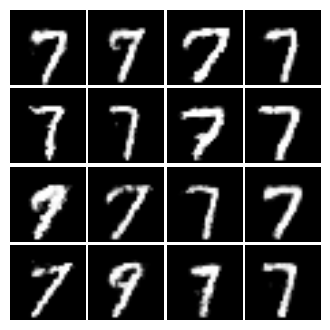

In [37]:
from IPython.display import Image

Image(filename= './out/095.png')

In [40]:
Z_sample.shape

(16, 100)

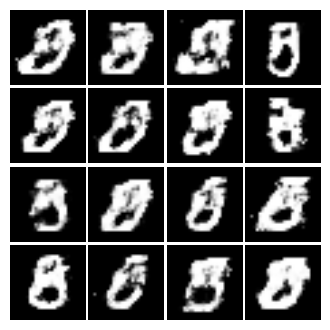

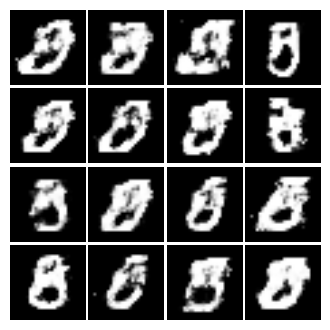

In [51]:
Z_sample = sample_Z(n_sample, Z_dim)
y_sample = np.zeros(shape=[n_sample, y_dim])
y_sample[:, [0,8,3]] = 1

samples = sess.run(G_sample, feed_dict={Z: Z_sample, y:y_sample})
plot(samples)